In [1]:
""" In this Colab, a MobileNet based model is created using Transfer Learning and then it is saved. It is loaded and trained on a training
dataset. A model can be saved in two formats, HDF5 format(Keras format) and SavedModel format(Tensorflow format). """

try:
  %tensorflow_version 2.x
except:
  pass

# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import logging
tf.get_logger().setLevel(logging.ERROR)
import time

TensorFlow 2.x selected.


In [2]:
# Preparing dataset
splits = tfds.Split.ALL.subsplit(weighted=(80,20))
(train_dataset,validation_dataset),info = tfds.load('cats_vs_dogs',split=splits,with_info=True,
                                                    as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [0]:
# Creating batches from dataset
def format_image(image,label):
    image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))/255.0
    return image,label
IMG_SIZE = 224
BATCH_SIZE = 32
num_examples = info.splits['train'].num_examples
train_batches = train_dataset.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_dataset.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
# Importing MobileNet model
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_SIZE,IMG_SIZE,3),trainable=False)

In [9]:
# Creating and Training the model
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2,activation='softmax')
])

model.compile(loss = tf.losses.SparseCategoricalCrossentropy(),
          optimizer='adam',
          metrics=['accuracy'])

epochs = 3
history = model.fit(train_batches,
                   validation_data=validation_batches,
                   epochs=epochs)

Epoch 1/3
582/582 [==============================] - 44s 75ms/step - loss: 0.0595 - accuracy: 0.9787 - val_loss: 0.0318 - val_accuracy: 0.9877
Epoch 2/3
582/582 [==============================] - 24s 41ms/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.0355 - val_accuracy: 0.9875
Epoch 3/3
582/582 [==============================] - 24s 41ms/step - loss: 0.0270 - accuracy: 0.9914 - val_loss: 0.0309 - val_accuracy: 0.9879


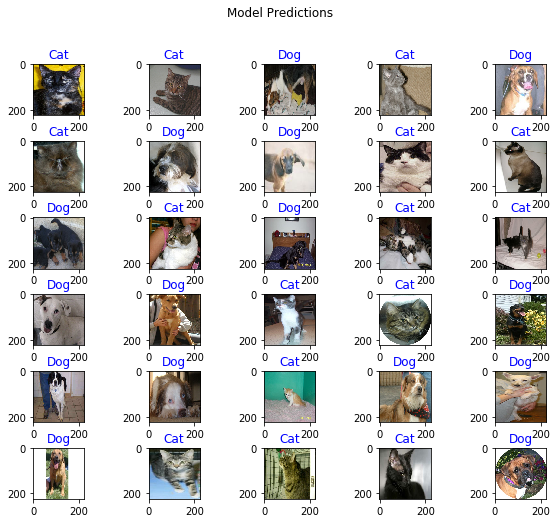

In [12]:
# Testing the model performance
class_names = np.array(info.features['label'].names)
image_batch,label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = tf.squeeze(model.predict(image_batch)).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_class_names = class_names[predicted_ids]

plt.figure(figsize=(10,8))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.5)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(),color = color)
_ = plt.suptitle("Model Predictions")

In [0]:
# Saving the model in HDF5 format(.h5 extension)
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
model.save(export_path_keras)
# This file saves following stuff:
# 1. Model's Architecture
# 2. Model's Weight values(learned during training)
# 3. Model's training config(whatevers passed during compile)
# 4. Optimizer and it's state(enables to restart training where it is left off)

In [14]:
# Loading the saved model. custom_objects parameter tells keras how to load hub.KerasLayer in feature_extractor
reloaded = tf.keras.models.load_model(export_path_keras,
                                      custom_objects={'KerasLayer':hub.KerasLayer})
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(result_batch-reloaded_result_batch).max() #Difference is zero

0.0

In [15]:
# Training the loaded model
history = reloaded.fit(train_batches,
                      validation_data=validation_batches,
                      epochs=epochs)

Epoch 1/3
582/582 [==============================] - 28s 47ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0317 - val_accuracy: 0.9879
Epoch 2/3
582/582 [==============================] - 24s 41ms/step - loss: 0.0200 - accuracy: 0.9931 - val_loss: 0.0318 - val_accuracy: 0.9881
Epoch 3/3
582/582 [==============================] - 24s 41ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0310 - val_accuracy: 0.9892


In [0]:
# Saving the model in SavedModel format
t = time.time()
export_path_sm = "./{}".format(int(t))
tf.saved_model.save(model,export_path_sm)
# SavedModel format allows deploying of this model to other platforms using TFLite, tf.js, etc.

In [22]:
reloaded_sm = tf.saved_model.load(export_path_sm)
reloaded_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()
abs(result_batch-reloaded_sm_result_batch).max()
# The object returned by tf.saved_model.load() is not a keras model and thus it doesn't have .fit, .predict, .summary methods

0.0

In [23]:
# We can load SavedModel as a Keras model using tf.keras.models.load_models(). We do this if we want to keep training our loaded model
reloaded_sm_keras = tf.keras.models.load_model(export_path_sm,
                                               custom_objects={'Keraslayer':hub.KerasLayer})
reloaded_sm_keras.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
# Predicting using reloaded_sm_keras
reloaded_sm_keras_result_batch = reloaded_sm_keras.predict(image_batch)
abs(reloaded_sm_keras_result_batch-result_batch).max()

0.0

In [26]:
# Downloading the model
!zip -r model.zip {export_path_sm} #Zipping the file in export_path_sm
try:
  from google.colab import files
  files.download("./model.zip") #Downloading the zipped file
except TypeError:
  pass

updating: 1579415706/ (stored 0%)
updating: 1579415706/assets/ (stored 0%)
updating: 1579415706/saved_model.pb (deflated 92%)
updating: 1579415706/variables/ (stored 0%)
updating: 1579415706/variables/variables.data-00000-of-00002 (deflated 88%)
updating: 1579415706/variables/variables.data-00001-of-00002 (deflated 7%)
updating: 1579415706/variables/variables.index (deflated 79%)
